In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

from glob import glob
from pathlib import Path

In [2]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROUTH'] = 'true'

In [5]:
exercise = 'exer2'

In [6]:
tr_set_group = sorted([x for x in Path(f"./dataset/{exercise}/raw/").glob("*.npy")])
tr_set_group

[WindowsPath('dataset/exer2/raw/raw_five_1670081688.npy'),
 WindowsPath('dataset/exer2/raw/raw_four_1670081688.npy'),
 WindowsPath('dataset/exer2/raw/raw_one_1670081688.npy'),
 WindowsPath('dataset/exer2/raw/raw_three_1670081688.npy'),
 WindowsPath('dataset/exer2/raw/raw_two_1670081688.npy')]

In [8]:
if exercise == 'exer1':
    actions = ['thumb','little']
elif exercise == 'exer2':
    actions = ['five', 'four', 'three', 'two', 'one']
else:
    actions = ['thumb','paper']
print(actions)

['five', 'four', 'three', 'two', 'one']


In [9]:
data = []

for fle in tr_set_group:
    if len(data) == 0:
        data = np.load(fle)
    else:
        data = np.concatenate([data, np.load(fle)], axis=0)

In [11]:
print(data.shape)
print(data[0][-1])

(2746, 100)
0.0


In [12]:
x_data = data[:,:-1]
labels = data[:,-1]

print(x_data.shape)
print(labels.shape)
print(labels)

(2746, 99)
(2746,)
[0. 0. 0. ... 3. 3. 3.]


In [13]:
y_data = to_categorical(labels, num_classes=len(actions))
print(y_data.shape)

(2746, 5)


In [14]:
x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_tr,x_val,y_tr,y_val = train_test_split(x_data, y_data, test_size=0.1, shuffle=True, random_state= 3)

print(x_tr.shape, y_tr.shape)
print(x_val.shape, y_val.shape)

(2471, 99) (2471, 5)
(275, 99) (275, 5)


In [18]:
print(x_tr.shape[1:3])
print(x_tr.shape[1:2])
print(x_tr[1:2][0])

(99,)
(99,)
[ 4.0594459e-01  6.9464952e-01 -3.1563886e-07  0.0000000e+00
  3.6909133e-01  6.6319352e-01  1.4532449e-02  0.0000000e+00
  3.5970673e-01  6.2063766e-01  2.2483222e-02  0.0000000e+00
  3.6800075e-01  5.8457470e-01  2.8762527e-02  0.0000000e+00
  3.8361007e-01  5.6840712e-01  3.5318065e-02  0.0000000e+00
  3.8645899e-01  5.6653982e-01  1.3553927e-02  0.0000000e+00
  3.9007059e-01  5.2962881e-01  2.0936681e-02  0.0000000e+00
  3.9099047e-01  5.4525268e-01  2.7703114e-02  0.0000000e+00
  3.9342180e-01  5.6385857e-01  3.1574331e-02  0.0000000e+00
  4.1470477e-01  5.6408828e-01  7.2811381e-03  0.0000000e+00
  4.1736990e-01  5.2783114e-01  1.2665122e-02  0.0000000e+00
  4.1790012e-01  5.3920728e-01  1.5910219e-02  0.0000000e+00
  4.1910914e-01  5.5208260e-01  1.7813977e-02  0.0000000e+00
  4.3749011e-01  5.7179898e-01  1.9373042e-03  0.0000000e+00
  4.4758251e-01  5.1945841e-01  7.3107565e-04  0.0000000e+00
  4.5622241e-01  4.8996925e-01 -5.0639184e-03  0.0000000e+00
  4.6328047e

In [20]:
model = Sequential([
    Dense(64, activation = 'relu', input_shape = x_tr.shape[1:2]),
    Dropout(0.2),
    Dense(32, activation = 'relu'),
    Dropout(0.4),
    Dense(16, activation ='relu'),
    Dense(len(actions), activation = 'softmax')
])

model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['acc']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 64)                6400      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 5)                 85        
                                                                 
Total params: 9,093
Trainable params: 9,093
Non-trainabl

In [21]:
history = model.fit(
    x_tr, y_tr,
    validation_data = (x_val, y_val),
    epochs = 1000,
    callbacks=[
        ModelCheckpoint(f'models/{exercise}/classifier_acc_raw.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ModelCheckpoint(f'models/{exercise}/classifier_loss_raw.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.05, patience=50, verbose=1, mode='auto'),
        EarlyStopping(monitor='val_loss', min_delta=0, patience=200, mode='auto')
    ]
)

Epoch 1/1000
64/78 [=======================>......] - ETA: 0s - loss: 1.9301 - acc: 0.5732
Epoch 1: val_acc improved from -inf to 0.98909, saving model to models/exer2\classifier_acc_raw.h5

Epoch 1: val_loss improved from inf to 0.21214, saving model to models/exer2\classifier_loss_raw.h5
78/78 [==============================] - 1s 8ms/step - loss: 1.6916 - acc: 0.6172 - val_loss: 0.2121 - val_acc: 0.9891 - lr: 0.0010
Epoch 2/1000
70/78 [=========================>....] - ETA: 0s - loss: 0.4054 - acc: 0.8741
Epoch 2: val_acc improved from 0.98909 to 0.99273, saving model to models/exer2\classifier_acc_raw.h5

Epoch 2: val_loss improved from 0.21214 to 0.04486, saving model to models/exer2\classifier_loss_raw.h5
78/78 [==============================] - 0s 4ms/step - loss: 0.3938 - acc: 0.8766 - val_loss: 0.0449 - val_acc: 0.9927 - lr: 0.0010
Epoch 3/1000
66/78 [========================>.....] - ETA: 0s - loss: 0.2522 - acc: 0.9295
Epoch 3: val_acc improved from 0.99273 to 0.99636, savin

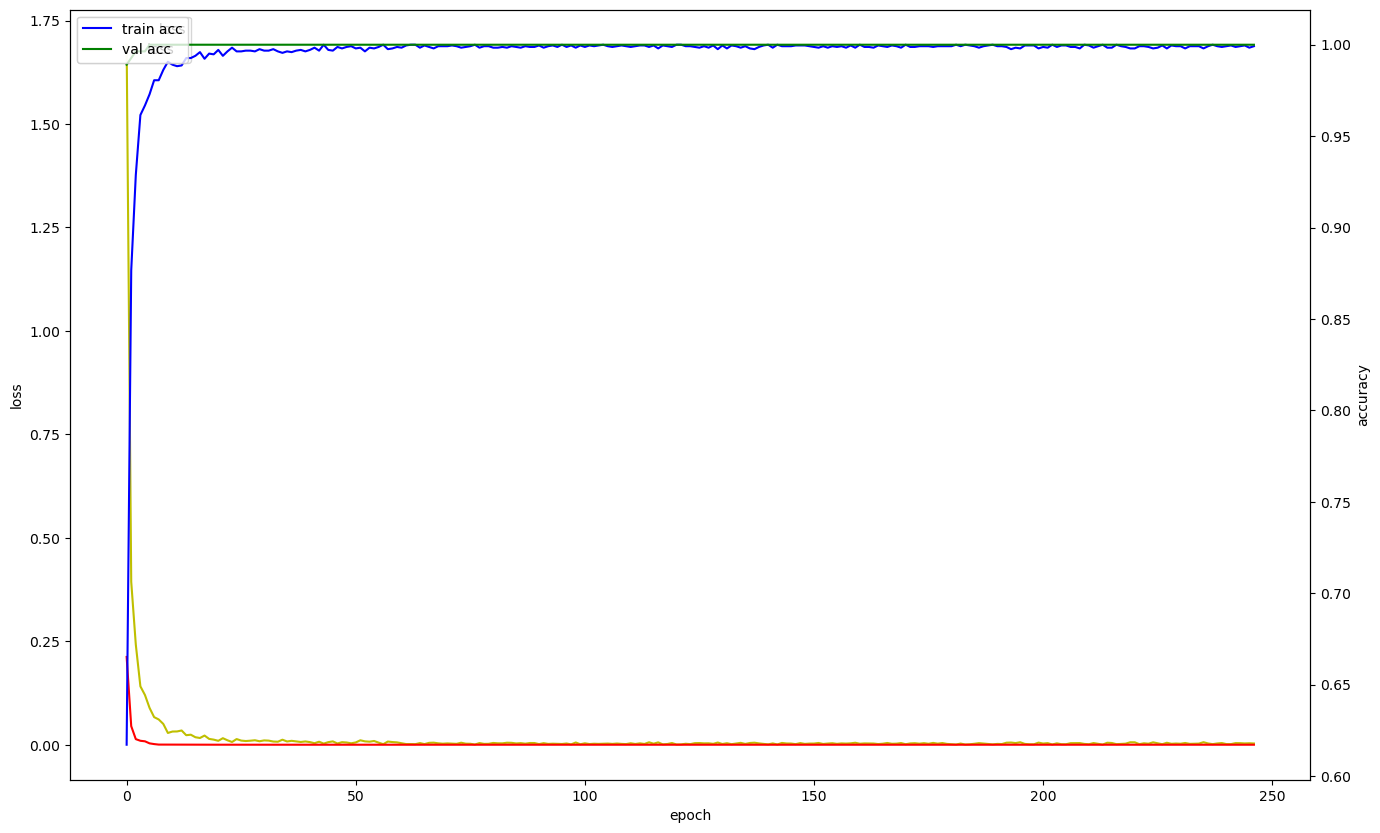

In [22]:
fig, loss_ax = plt.subplots(figsize=(16,10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'],'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'],'b', label='train acc')
acc_ax.plot(history.history['val_acc'],'g',label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()